In [1]:
import psutil
import os

def print_mem():
    gig = psutil.Process(os.getpid()).memory_info().rss / 1024 ** 3
    print(f"{gig} gigabytes")

In [2]:
print_mem()

0.0647735595703125 gigabytes


In [3]:
# sub_categories = ["All_Beauty", "Subscription_Boxes", "Magazine_Subscriptions", "Health_and_Personal_Care", "Handmade_Products", "Gift_Cards", "Digital_Music", "Appliances"]
sub_categories = ["Gift_Cards", "Digital_Music", "Magazine_Subscriptions", "Subscription_Boxes"]

In [4]:
from datasets import load_dataset

review_datasets_list = []
meta_dataset_list = []
for sub_cat in sub_categories:
    print(f"Loading review dataset for sub category {sub_cat}")
    sub_cat_dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"raw_review_{sub_cat}", split="full", trust_remote_code=True)
    review_datasets_list.append(sub_cat_dataset)
    
    print(f"Loading metadata dataset for sub category {sub_cat}")
    sub_cat_dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"raw_meta_{sub_cat}", split="full", trust_remote_code=True)
    meta_dataset_list.append(sub_cat_dataset)

Loading review dataset for sub category Gift_Cards
Loading metadata dataset for sub category Gift_Cards
Loading review dataset for sub category Digital_Music
Loading metadata dataset for sub category Digital_Music
Loading review dataset for sub category Magazine_Subscriptions
Loading metadata dataset for sub category Magazine_Subscriptions
Loading review dataset for sub category Subscription_Boxes
Loading metadata dataset for sub category Subscription_Boxes


In [5]:
from datasets import concatenate_datasets

In [6]:
review_dataset = concatenate_datasets(review_datasets_list)
meta_dataset = concatenate_datasets(meta_dataset_list)

In [7]:
print_mem()

0.17583465576171875 gigabytes


In [8]:
review_dataset, meta_dataset

(Dataset({
     features: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase'],
     num_rows: 370557
 }),
 Dataset({
     features: ['main_category', 'title', 'average_rating', 'rating_number', 'features', 'description', 'price', 'images', 'videos', 'store', 'categories', 'details', 'parent_asin', 'bought_together', 'subtitle', 'author'],
     num_rows: 75706
 }))

In [9]:
meta_dataset = meta_dataset.rename_column("title", "item_title")

In [10]:
meta_dataset[0]

{'main_category': 'Gift Cards',
 'item_title': 'Amazon.com Gift Card in Gift Tag (Various Designs)',
 'average_rating': 4.8,
 'rating_number': 1006,
 'features': ['Gift Card is affixed inside a gift tag',
  'Gift amount may not be printed on Gift Cards',
  'Gift Card has no fees and no expiration date',
  'No returns and no refunds on Gift Cards',
  'Gift Card is redeemable towards millions of items storewide at Amazon.com',
  'Scan and redeem any Gift Card with a mobile or tablet device via the Amazon App',
  'Free One-Day Shipping (where available)',
  'Customized gift message, if chosen at check-out, only appears on packing slip and not on the actual gift card or carrier'],
 'description': ["Amazon.com Gift Cards are the perfect way to give them exactly what they're hoping for - even if you don't know what it is. Amazon.com Gift Cards are redeemable for millions of items across Amazon.com. Item delivered is a single physical Amazon.com Gift Card nested inside or with a free gift acc

In [12]:
len(review_dataset)

370557

In [13]:
review_selected_cols = ["rating", "title", "text", "parent_asin", "user_id", "timestamp", "helpful_vote", "verified_purchase"]
meta_selected_cols = ["main_category", "title", "average_rating", "rating_number", "features", "description", "price", "store", "categories", "details", "parent_asin"]

In [14]:
review_dataset

Dataset({
    features: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase'],
    num_rows: 370557
})

In [15]:
meta_df = meta_dataset.to_pandas()
review_df = review_dataset.to_pandas()

In [16]:
review_selected_cols = ["rating", "title", "text", "parent_asin", "user_id", "timestamp", "helpful_vote", "verified_purchase"]
meta_selected_cols = ["main_category", "item_title", "average_rating", "rating_number", "features", "description", "price", "store", "categories", "details", "parent_asin"]
merge_df = review_df[review_selected_cols].merge(meta_df[meta_selected_cols], on="parent_asin")

In [17]:
merge_df["title_text"] = merge_df.apply(lambda x: f"{x['title']}\n{x['text']}", axis=1)

In [ ]:
sub_categories

In [18]:
len(merge_df)

370557

In [19]:
from datasets.features import Value, Sequence, Features

features = Features({
     'rating': Value(dtype='float64', id=None),
     'title': Value(dtype='string', id=None),
     'title_text': Value(dtype='string', id=None),
     'text': Value(dtype='string', id=None),
     'parent_asin': Value(dtype='string', id=None),
     'user_id': Value(dtype='string', id=None),
     'timestamp': Value(dtype='int64', id=None),
     'helpful_vote': Value(dtype='int64', id=None),
     'verified_purchase': Value(dtype='bool', id=None),
     'main_category': Value(dtype='string', id=None),
     'item_title': Value(dtype='string', id=None),
     'average_rating': Value(dtype='float64', id=None),
     'rating_number': Value(dtype='int64', id=None),
     'features': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
     'description': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
     'price': Value(dtype='string', id=None),
     'store': Value(dtype='string', id=None),
     'categories': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
     'details': Value(dtype='string', id=None)})

In [20]:
from datasets import Dataset, concatenate_datasets
from tqdm.notebook import tqdm

chunk_size = 5000  # Adjust this based on your memory capacity
datasets_list = []

for i in tqdm(range(0, len(merge_df), chunk_size)):
    chunk = merge_df.iloc[i:i + chunk_size]
    datasets_list.append(Dataset.from_pandas(chunk, features))

# Concatenate all chunks into one dataset
final_dataset = concatenate_datasets(datasets_list)

  0%|          | 0/75 [00:00<?, ?it/s]

In [28]:
sample_dataset = final_dataset.shuffle().select(range(10000))

In [30]:
sample_dataset

Dataset({
    features: ['rating', 'title', 'title_text', 'text', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase', 'main_category', 'item_title', 'average_rating', 'rating_number', 'features', 'description', 'price', 'store', 'categories', 'details'],
    num_rows: 10000
})

In [22]:
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModel
from umap import UMAP
import datasets
import numpy as np
import torch

datasets.logging.set_verbosity_error()

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed_all(SEED)

In [23]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def embed_sentence_pairs(dataloader, tokenizer, model, disable_tqdm=False):
    review_embeddings  = []
    item_embeddings = []
    feature_embeddings = []

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model.to(device)
    model.eval()

    loop = tqdm(dataloader, desc=f"Embedding sentences...", disable=disable_tqdm)
    for data in loop:

        review, item = [record['title_text'] for record in data], [record['item_title'] for record in data]
        # print(f"review batch: {review}")
        encoded_review, encoded_item = (
            tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
            for sentences in (review, item)
        )

        # Compute token embeddings
        with torch.no_grad():
            encoded_review = encoded_review.to(device)
            encoded_item = encoded_item.to(device)
            model_review_output = model(**encoded_review)
            model_item_output = model(**encoded_item)

        # Perform pooling
        pooled_review = mean_pooling(model_review_output, encoded_review['attention_mask']).cpu().numpy()
        pooled_item = mean_pooling(model_item_output, encoded_item['attention_mask']).cpu().numpy()
    
        review_embeddings.extend(pooled_review)
        item_embeddings.extend(pooled_item)

        
    # Concatenate premise and hypothesis embeddings, as well as their absolute difference
    feature_embeddings = np.concatenate(
        [
            np.array(review_embeddings),
            np.array(item_embeddings),
            np.abs(np.array(review_embeddings) - np.array(item_embeddings))
        ],
        axis=1
    )
    # feature_embeddings = normalize(feature_embeddings, norm='l2', axis=1)
    return feature_embeddings

In [31]:
# model_name = 'sentence-transformers/all-MiniLM-L6-v2'

# # Uncomment the following line to try a regular Transformers model trained on MultiNLI
# # model_name = 'sileod/roberta-base-mnli'

# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModel.from_pretrained(model_name)

# batch_size = 128

# # Place Hugging Face datasets in a PyTorch DataLoader
# loader = DataLoader(sample_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: x)

# # Get embeddings
# embeddings = embed_sentence_pairs(loader, tokenizer, model, disable_tqdm=False)

Embedding sentences...:   0%|          | 0/79 [00:00<?, ?it/s]

In [217]:
from sentence_transformers import SentenceTransformer

transformer = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
raw_texts = sample_dataset["text"]
text_embeddings = transformer.encode(raw_texts)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/Users/mouhaned.chebaane/Library/Caches/pypoetry/virtualenvs/abwab-homework-r5ZhboOE-py3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [218]:
text_embeddings.shape

(10000, 384)

In [123]:
dist_embds = embeddings[:,-384:]
dist_embds.shape

(10000, 384)

In [44]:
sample_df = sample_dataset.to_pandas()

In [49]:
sample_df['price'] = sample_df['price'].apply(lambda x: float(x) if x != "None" else None)

In [50]:
sample_df['price'] = sample_df['price'].fillna(sample_df['price'].mean())


In [108]:
all_cats = ['Digital Music', 'Gift Cards', 'Magazine Subscriptions',
       'SUBSCRIPTION BOXES', 'Amazon Home', 'Health & Personal Care',
       'Grocery', 'Software', 'Office Products']

cat_2_idx = {cat: idx for idx, cat in enumerate(all_cats)}

In [107]:
sample_df.main_category.unique()

array([None, 'Digital Music', 'Gift Cards', 'Magazine Subscriptions',
       'SUBSCRIPTION BOXES', 'Amazon Home', 'Health & Personal Care',
       'Grocery', 'Software', 'Office Products'], dtype=object)

In [110]:
sample_df.main_category.map(lambda x: x in cat_2_idx if x else False)

0       False
1        True
2        True
3       False
4        True
        ...  
9995     True
9996     True
9997     True
9998    False
9999    False
Name: main_category, Length: 10000, dtype: bool

In [111]:
sample_df['category_encoded'] = sample_df.main_category.map(lambda x: cat_2_idx[x] if x else None)
sample_df['category_encoded']

0       NaN
1       0.0
2       1.0
3       NaN
4       0.0
       ... 
9995    1.0
9996    0.0
9997    1.0
9998    NaN
9999    NaN
Name: category_encoded, Length: 10000, dtype: float64

In [113]:
sample_df['category_encoded'] = sample_df['category_encoded'].ffill()
sample_df['category_encoded'] = sample_df['category_encoded'].bfill()
sample_df['category_encoded']

0       0.0
1       0.0
2       1.0
3       1.0
4       0.0
       ... 
9995    1.0
9996    0.0
9997    1.0
9998    1.0
9999    1.0
Name: category_encoded, Length: 10000, dtype: float64

In [257]:
cols = ["rating", "helpful_vote", "price", "average_rating", "rating_number", "verified_purchase"]

In [258]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

df_to_scale = sample_df[cols]

# Fit and transform the data
df_scaled = pd.DataFrame(scaler.fit_transform(df_to_scale), columns=df_to_scale.columns)

In [260]:
X_combined = np.hstack((df_scaled, text_embeddings))
X_combined.shape, text_embeddings.shape

((10000, 390), (10000, 384))

In [261]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(contamination=0.025)  # Set contamination rate
model.fit(X_combined)
anomalies = model.predict(X_combined)

In [262]:
anomalies.sum(), len(anomalies)

(9500, 10000)

In [263]:
anomaly_idxs = np.where(anomalies == -1)[0]
sample_dataset.select(anomaly_idxs).to_pandas().head(5).style

,rating,title,title_text,text,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,main_category,item_title,average_rating,rating_number,features,description,price,store,categories,details
0,4.000000,Christmas in the Tropics,Christmas in the Tropics A unique blend of Christmas songs with a tropical theme. 12 songs:1 Little Drummer Boy - Vince Charles2 Have Yourself a Merry Little Christmas - Pancho Sanchez3 Sound The Trumpet - The Wailers feat. Bob Marley4 Irie Christmas - Freddie McGregor5 Winter Wonderland - Barney Isaacs & George Kuo6 Mele Kalikimaka - Steel Tropics7 Sleigh Ride - Caribbean Jazz Project8 Santa Claus Is Coming To Town - Ed Calle & Arturo Sandoval9. Feliz Navidad - Pete Escoverdo & Ray Obiedo10 Joy To The World - The Red Hot Jalapenos11 Christmas Time Is Here - The Heptones12 Jingle Bell Rock - Ozzie Kotani,A unique blend of Christmas songs with a tropical theme. 12 songs:1 Little Drummer Boy - Vince Charles2 Have Yourself a Merry Little Christmas - Pancho Sanchez3 Sound The Trumpet - The Wailers feat. Bob Marley4 Irie Christmas - Freddie McGregor5 Winter Wonderland - Barney Isaacs & George Kuo6 Mele Kalikimaka - Steel Tropics7 Sleigh Ride - Caribbean Jazz Project8 Santa Claus Is Coming To Town - Ed Calle & Arturo Sandoval9. Feliz Navidad - Pete Escoverdo & Ray Obiedo10 Joy To The World - The Red Hot Jalapenos11 Christmas Time Is Here - The Heptones12 Jingle Bell Rock - Ozzie Kotani,B000GF1ZOE,AGDOIKOOJNCYIUSRQQP6SBUGKATA,1482393909000,0,False,Digital Music,Happy Huladays,4.800000,2,[],['1.little drummer boy.2.have your self a merry christmas.3.sound the trumpet.4.irie christmas.5.winter wonderland.6.mele kalikimaka.7.sleigh ride.8.santa claus is comin to town.9.feliz navidad.10.joy to the world.11.christmas time is here.12.jingle bell rock'],22.43,Tommy Bahama (Author) Format: Audio CD,[],"{""Is Discontinued By Manufacturer"": ""No"", ""Package Dimensions"": ""5.55 x 4.97 x 0.54 inches; 2.83 Ounces"", ""Date First Available"": ""June 20, 2006"", ""Number of discs"": ""1""}"
1,5.000000,You can use it anywhere,You can use it anywhere You can use it anywhere,You can use it anywhere,B01MSBQB1P,AGIYRYDCSB5AR4M7IAZEVZPE4PPQ,1576668550169,0,False,None,Visa $100 Gift Card (plus $5.95 Purchase Fee),4.700000,34085,"['This card is non-reloadable. No expiration of funds. No cash or ATM access. Cards are shipped ready to use.' 'This card can be used in the U.S. only, online or in stores, where Visa debit cards are accepted. Your Amazon.com Balance cannot be used to purchase Visa gift cards. For FAQ’s on how to use your Visa prepaid gift card please visit mygift.giftcardmall.com for more information.' 'A one-time $5.95 purchase fee applies at the time of purchase. No fees after purchase (including dormancy, service or other fees).' 'This item is not eligible for refund or return. Available for sale within the United States only (not available to Puerto Rico residents). Additional shipping restrictions apply to Hawaii, Kansas, New Mexico, South Dakota, US Virgin Islands, Vermont, and West Virginia.' 'Do not provide any gift card details (such as the claim code) to someone you do not know or trust. There are a variety of scams in which fraudsters try to trick others into paying with gift cards. We want to make sure our customers are aware of potential scams that may involve asking for payment using gift cards. See ""Be Informed"" link at the top of the page to learn more.']",[],105.95,Visa,"['Gift Cards' 'Gift Card Categories' 'Clothing, Shoes & Accessories']","{""Is Discontinued By Manufacturer"": ""No"", ""Package Dimensions"": ""5.2 x 4 x 0.1 inches; 0.63 Ounces"", ""Date First Available"": ""March 28, 2017""}"
2,5.000000,Perfecto,Perfecto Facil de usar,Facil de usar,B00IX1I3G6,AHTMS4ZGTNXMGHH7GKTZYV7UNTFQ,1601857963773,0,True,None,Amazon Reload,4.700000,143309,"['Add funds to your Amazon Gift Card balance, then use your balance to manage how much you spend while shopping.' 'Save up for a purchase by adding funds

In [264]:
from cleanlab.outlier import OutOfDistribution

# Get outlier scores for each of the data feature embeddings
ood = OutOfDistribution()
outlier_scores = ood.fit_score(features=X_combined)

Fitting OOD estimator based on provided features ...


In [265]:
top_outlier_idxs = (outlier_scores).argsort()[:15]
top_outlier_subset = sample_dataset.select(top_outlier_idxs)
top_outlier_subset.to_pandas().head()

,rating,title,title_text,text,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,main_category,item_title,average_rating,rating_number,features,description,price,store,categories,details
0,1.0,Caution -- NOT Proper-Sheppard's band!!!,"Caution -- NOT Proper-Sheppard's band!!!\nNo, ...","No, this is not an undiscovered gem by Robin P...",B000WMG4PQ,AGJA7KXM6PMPAN64VVDZDKTYUBVQ,1220888388000,17,False,Digital Music,Law of Retailiation,1.0,1,[],[],14.75,The God Machine Format: Audio CD,[],"{""Package Dimensions"": ""5.55 x 4.97 x 0.54 inc..."
1,1.0,"MISLEADING ""You'll love it guarentee""","MISLEADING ""You'll love it guarentee""\nMy Wife...",My Wife and I ordered a one year subscription ...,B00A7C9BOW,AHCGR55I2ENDMD57JRLHXWU3R33A,1612474459608,2,False,None,Amazing Clubs Gift Card 1000,1.0,3,[Gift of the Month Clubs are the perfect gift ...,[],None,Amazing Clubs,"[Gift Cards, Gift Card Categories, Clothing, S...",{}
2,1.0,The whole book series is great.,The whole book series is great.\nAs great as t...,"As great as this book is, you must be as high ...",B00SB4O8UU,AFZ42S6TEFDOOBJKJLOK7FZJSH5A,1531327761843,0,False,Digital Music,By John Sandford Chosen Prey (Abridged) [Audio...,1.0,1,[],[],None,John Sandford Format: Audio CD,[],"{""Manufacturer"": ""Penguin Audio"", ""Date First ..."
3,1.0,10 Songs for $40 on this CD,10 Songs for $40 on this CD\nI like the choice...,I like the choices but hate the price. I'll co...,B0176ZPSQC,AEIB7NMXZIMZXZ5FHH3RIDY7CWLQ,1577864587815,0,False,Digital Music,Dimsa Mexico Su Magia y su Musica Los Cantante...,1.0,1,[],"[Pedro Infante, Jorge Negrete, Vicente Fernand...",None,"Pedro Infante, Jorge Negrete, Vicente Fernande...",[],"{""Manufacturer"": ""Orfeon"", ""Date First Availab..."
4,1.0,This is not an album put together or authorize...,This is not an album put together or authorize...,This is not an album put together or authorize...,B00JEEW0WO,AHVHP7KSUXP3N5LTFD7B5DAGC37A,1432066309000,0,False,Digital Music,Country Ballads Featuring Dusty Owens,1.0,1,[],[],11.01,None,[],"{""Date First Available"": ""September 1, 2015""}"


In [273]:
top_outlier_subset.to_pandas()[["rating", "title", "text", "item_title", "store", "details"]].head(20).style

,rating,title,text,item_title,store,details
0,1.000000,Caution -- NOT Proper-Sheppard's band!!!,"No, this is not an undiscovered gem by Robin Propper-Sheppard's God Machine! This ""God Machine"" is a four piece band from the Seattle Washington area. Truly below-average hard rock of the minimally-imaginative, only-partially-intelligible variety. Next...",Law of Retailiation,The God Machine Format: Audio CD,"{""Package Dimensions"": ""5.55 x 4.97 x 0.54 inches; 3.1 Ounces"", ""Date First Available"": ""October 30, 2012""}"
1,1.000000,"MISLEADING ""You'll love it guarentee""","My Wife and I ordered a one year subscription from them for the Ice Cream of the month club. Our first 4 pints came and we were very pleased. We did get batch Ice Cream from lesser known creameries/shops within the United States. Most of the offerings were pretty good, one was FANTASTIC. The second shipment arrived, this time two were tame in comparison to the initial delivery, one was unique and the other was again, AWESOME. It was delivery number 3 that was terrible. Instead of small batch, craft-esque, unique Ice Cream, we got 4 pints that carried an Amazing Clubs brand and packaging. The flavors were not unique, they tasted terrible and I contacted amazing clubs. I explained the let down through email support. I was given a canned answer, something like "" Were very sorry you did not enjoy your selection, we'll take your comments and discuss with our elfs"" ....something like that. I don't know if I called or not. The RUB here is the guarantee that you'll love it. It's SUPER MISLEADING. I don't think you should ever ""eat the steak"" then complain and try to get something for free, but on the surface to a lay person wanting a ""push"" to purchase that there's some kind of Guarantee, it's a fair assumption that the guarantee would be for the dislike of the product. This is my hang-up and why the advertising is quasi DECEITFUL. I got my fourth and final order on 2/3/2021. I opened the box and got four generic, house branded Ice Creams. NOT UNIQUE, NOT CRAFT OR SMALL BATCH. The same crappy, uninteresting, boring pints. Mint Oreo, Chocolate Brownie, Carmel Coconut and Butter Pecan (which was damaged) cracked lid and ice cream coming out of container. It's what it is, it was meant to be fun but unfortunately it was only 2 shipments out of four that we had fun with. I thought after my email that I sent they may have taken into consideration selecting something much better, but they didn't. They fail at customer service, they let me down on what was something exciting by not continuing with their initial momentum. Had all deliveries been from unique places with wild flavors all the way through my subscription I wouldn't have hesitated to re-up my subscription. It's too bad. Now to address one more thought, the person who replies to all the complaints is not cool. The written sentiment to others that the author THINKS is amusing or snarky is really just belittling, berating and rude. I know consumers aren't always right, but a complaint of any kind shouldn't be handled like that. The author who responds to complaints reminds me of the kids who were the type to stand by the front doors of their own homes, curse at me, flip me the bird and when I'd begin to approach they'd run inside. You know, that kinda tough guy...the ones who really aren't. Not a good look amazingclubs.com! I wouldn't recommend this company to anyone, and obviously I will not be ordering from this company in the future.",Amazing Clubs Gift Card 1000,Amazing Clubs,{}
2,1.000000,The whole book series is great.,"As great as this book is, you must be as high as the price is if you think I'm going to spend over $3000 for it.",By John Sandford Chosen Prey (Abridged) [Audio CD],John Sandford Format: Audio CD,"{""Manufacturer"": ""Penguin Audio"", ""Date First Available"": ""January 16, 2015"", ""Label"": ""Penguin Audio""}"
3,1.000000,10 Songs for $40 on this CD,I like the choices but hate the price

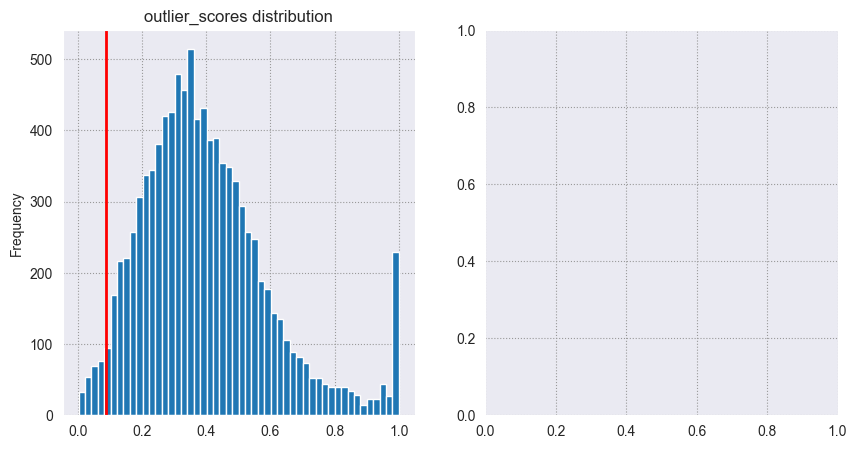

In [268]:
import matplotlib.pyplot as plt

threshold = np.percentile(outlier_scores, 2.5)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plt_range = [outlier_scores.min(), outlier_scores.max()]

axes[0].hist(outlier_scores, range=plt_range, bins=50)
axes[0].set(title='outlier_scores distribution', ylabel='Frequency')
axes[0].axvline(x=threshold, color='red', linewidth=2)

In [269]:

# Get embeddings of test examples whose outlier scores are below the threshold

sorted_ids = outlier_scores.argsort()
outlier_scores = outlier_scores[sorted_ids]
outlier_ids = sorted_ids[outlier_scores < threshold]

selected_outlier_subset = sample_dataset.select(outlier_ids)
selected_outlier_subset.to_pandas().tail(15)

,rating,title,title_text,text,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,main_category,item_title,average_rating,rating_number,features,description,price,store,categories,details
235,1.0,Connections Account not safe for gift cards,Connections Account not safe for gift cards\nW...,We purchase gift cards every year from Cinemar...,B07HFRK73L,AFOCIRLT5UJBATOE6O62TXHBU77A,1550206344731,3,False,Gift Cards,Cinemark Theatres Gift Card,4.8,1046,"[Redemption: Instore and Online, No returns an...",[],50.0,SVQQPE,"[Gift Cards, Gift Card Categories, Specialty C...","{""Package Dimensions"": ""5.3 x 4.2 x 0.05 inche..."
236,1.0,One Star,One Star\nCover and sleeve in deplorable condi...,Cover and sleeve in deplorable condition. Woul...,B0012N8WTK,AFMPRZDFLCOON7NVJE254VHIKZLA,1420498636000,0,True,Digital Music,The Many Voices of Miriam Makeba,3.5,3,[],[lp Record Label Name: Kapp Records Label's Ca...,5.11,Miriam Makeba (Author) Format: Unknown Bin...,[],"{""Package Dimensions"": ""12.1 x 12.1 x 0.2 inch..."
237,1.0,Like & don't like,"Like & don't like\nLIKE the cute pattern, bein...","LIKE the cute pattern, being surprised<br />DI...",B08H5PFVQM,AEFM4WGATCLWNJA5MCCS5AXIU5CA,1612315726842,18,True,SUBSCRIPTION BOXES,Fun Sock Subscription Box by Foot Cardigan - A...,4.1,323,[HIGH QUALITY: Your men’s subscription box soc...,[],None,Foot Cardigan,[],{}
238,1.0,This sucks,"This sucks\nBought for box, but came beat up. ...","Bought for box, but came beat up. Plus it took...",B00ADR2LV6,AFOT5OIT7327RCAQC3QU2LZODYRA,1611024985494,0,False,Gift Cards,Amazon.com Gift Card in a Holiday Gift Box (Va...,4.9,185606,"[Gift Card is affixed inside a box, Gift amoun...",[],25.0,Amazon,"[Gift Cards, Occasions, Chanukah]","{""Package Dimensions"": ""8.19 x 4.41 x 1.3 inch..."
239,1.0,Cheaply made,Cheaply made\nI thought the colors would be vi...,I thought the colors would be vibrant,B09F3CPZCG,AHXE55VODYKCUMBR4EQOSH72ZJXA,1651493702079,0,True,SUBSCRIPTION BOXES,JoJo Siwa T-Shirt Club Subscription,4.1,36,[WHAT IS T-SHIRT CLUB? Created for the ultimat...,[],None,JoJo Siwa,[],{}
240,3.0,Show your Welsh Pony every weekend? This is yo...,Show your Welsh Pony every weekend? This is yo...,I received a subscription of this magazine for...,B00005NIPY,AGKFV34QFHTU3EYIDBVMCDP6INJQ,1030245762000,113,False,Magazine Subscriptions,Young Rider,4.2,254,[],[],None,Eg Media Investments Llc,"[Magazine Subscriptions, Children & Teen, Chil...","{""Date First Available"": ""September 19, 2006""}"
241,1.0,Not engaging,Not engaging\nNot stimulating or engaging for ...,Not stimulating or engaging for my kids. I’m s...,B07QWTTPK7,AH65ME5HNB4DUXXFONIAX3G2RGMA,1564011101621,9,True,SUBSCRIPTION BOXES,STEM Discovery Boxes Monthly Kids Science Kit ...,4.2,156,[STEM SCIENCE DELIVERED RIGHT TO YOUR DOOR - E...,[],None,STEM Discovery Boxes,[],{}
242,4.0,"A success on all (er, most) counts","A success on all (er, most) counts\nGoing in t...","Going in to ""Attack of the Clones"" (hereafter,...",B00003CXKT,AHDBVHTP5I2LJTEJ4POBJRYXF2XA,1022189123000,2,False,Digital Music,Test Big Data 1737,3.6,429,[],[],None,None,[],"{""Date First Available"": ""January 29, 2016""}"
243,3.0,Inconsistant... but has bright spots,Inconsistant... but has bright spots\nWhile ma...,"While many complain about him having a ""small ...",B00004X16D,AHLYVECKBLI3XPXFPLEIBDPHSXSQ,1054463267000,3,False,Digital Music,Verdi,4.6,92,[],"[Verdi CD Philips, 464 600-2, 2000, 15 Track]",8.0,"Mehta/Israel Phil Orch (Contributor), Boc...",[],"{""Is Discontinued By Manufacturer"": ""No"", ""Lan..."
244,1.0,Un desastre,Un desastre\nPésimo vendedor llegó retrasado y...,Pésimo vendedor llegó retrasado y lo peor canc...,B0000246BT,AF7QP2WB5HJLC5UC5BIFQUUBSZGA,1573419856547,0,True,Digital Music,"Modern Talking, Fancy, Ivan, Al Corley, Baltim...",3.7,10,[],[],136.0,Format: Audio CD,[],"{""Package Dimensions"": ""5.55 x 4.97 x 0.54 inc..."


In [306]:
selected_outlier_subset.to_pandas().verified_purchase.value_counts()

verified_purchase
False    219
True      31
Name: count, dtype: int64

In [270]:
selected_outlier_subset.to_pandas().rating.value_counts()

rating
1.0    162
2.0     40
3.0     32
5.0      8
4.0      8
Name: count, dtype: int64

/Users/mouhaned.chebaane/Library/Caches/pypoetry/virtualenvs/abwab-homework-r5ZhboOE-py3.11/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


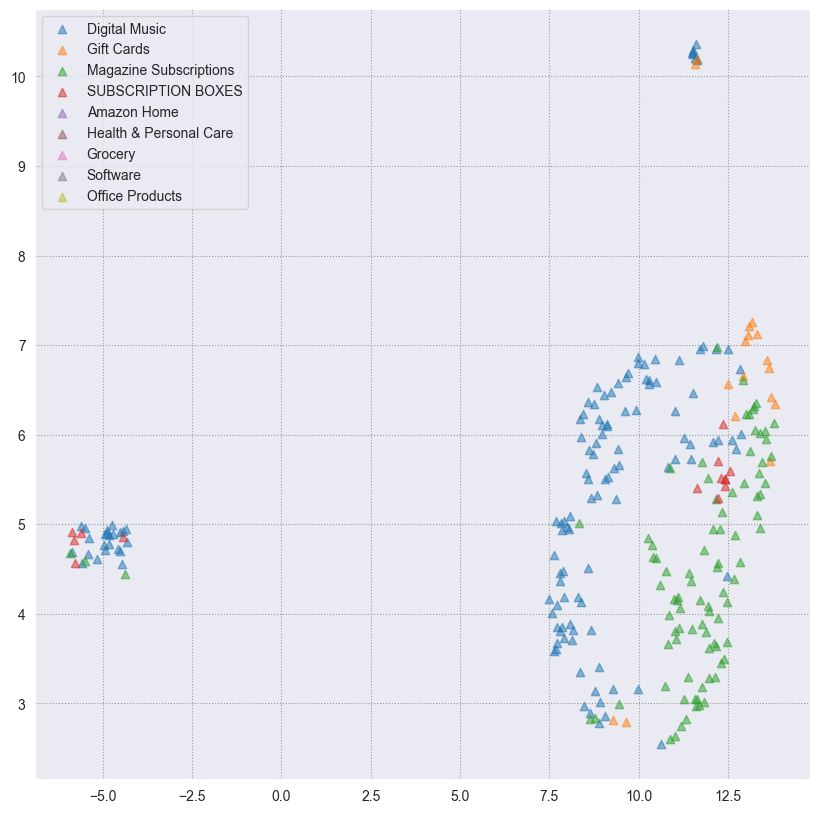

In [271]:
# Get embeddings of selected outliers
selected_outlier_subset_embeddings = X_combined[outlier_ids]

# Reduce dimensionality with UMAP
umap_fit = UMAP(n_components=2, n_neighbors=8, random_state=SEED)
selected_outlier_subset_embeddings_umap = umap_fit.fit_transform(selected_outlier_subset_embeddings)

# Set plot labels
mismatched_labels = {"nineeleven": 0, "facetoface": 1, "letters": 2, "oup": 3, "verbatim": 4}
matched_labels = {"fiction": 5, "government": 6, "slate": 7, "telephone": 8, "travel": 9}
labels_dict = {**mismatched_labels, **matched_labels}
genre_labels = np.array([cat_2_idx.get(x, 0) for x in selected_outlier_subset["main_category"]])

# Plot reduced embeddings
plt.figure(figsize=(10, 10))
x_plot, y_plot = selected_outlier_subset_embeddings_umap[:, 0], selected_outlier_subset_embeddings_umap[:, 1]

for i, genre in enumerate(cat_2_idx.keys()):
    x, y = x_plot[genre_labels == i], y_plot[genre_labels == i]
    if genre in mismatched_labels:
        # Mismatched genres are filled circles
        plt.scatter(x, y, label=genre)
    else:
        # Matched genres are transparent triangles
        plt.scatter(x, y, label=genre, alpha=0.5, marker="^")
plt.legend()

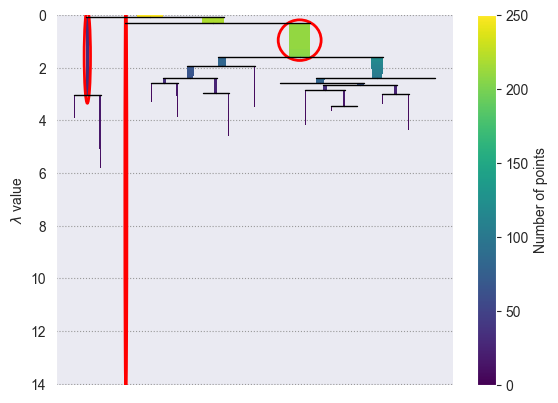

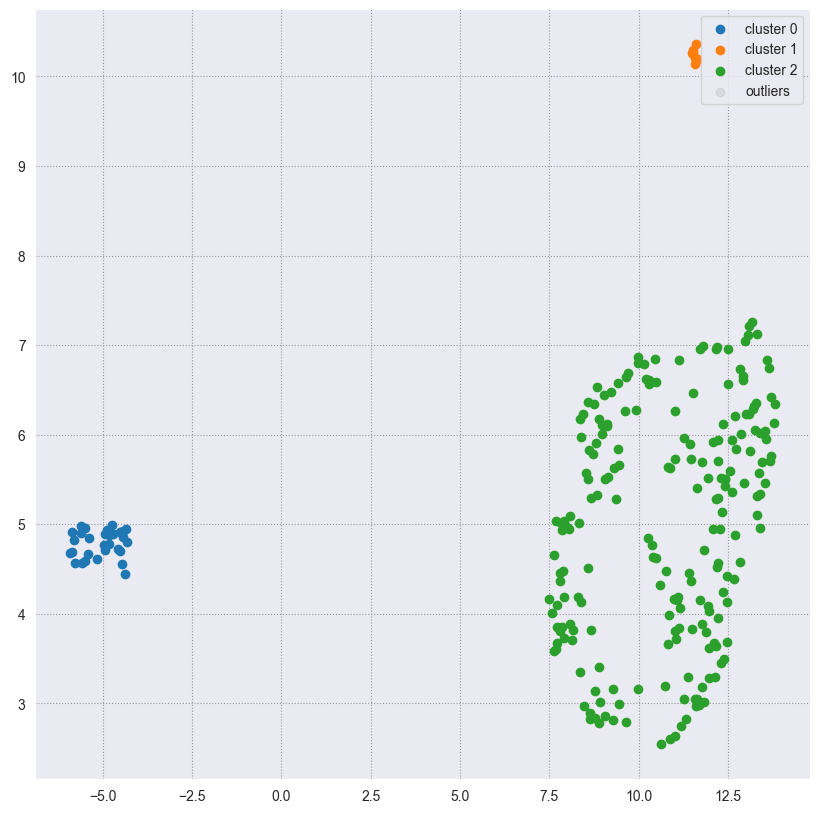

In [272]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=6, min_samples=4)
clusterer.fit(selected_outlier_subset_embeddings_umap)
cluster_labels = clusterer.labels_

clusterer.condensed_tree_.plot(select_clusters=True)

# plot each set of points in a different color
plt.figure(figsize=(10, 10))
for i in np.unique(cluster_labels):
    if i != -1:
        x, y = x_plot[cluster_labels == i], y_plot[cluster_labels == i]
        plt.scatter(x, y, label=f"cluster {i}")

# Plot outliers in gray
x, y = x_plot[cluster_labels == -1], y_plot[cluster_labels == -1]
plt.scatter(x, y, label="outliers", color="gray", alpha=0.15)
plt.legend()

In [160]:
embeddings.shape[1] / 3

384.0

In [161]:
first_embds = embeddings[:,:384]

In [287]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=0, n_iter=1000)
tsne_results = tsne.fit_transform(X_combined)

df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
df_tsne['Class Name'] = sample_dataset["main_category"]
df_tsne

/Users/mouhaned.chebaane/Library/Caches/pypoetry/virtualenvs/abwab-homework-r5ZhboOE-py3.11/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


,TSNE1,TSNE2,Class Name
0,46.900604,12.119479,None
1,-2.360526,32.546761,Digital Music
2,57.541004,27.913895,Gift Cards
3,29.613556,-44.515800,None
4,1.503574,63.034668,Digital Music
...,...,...,...
9995,-9.839675,-53.809864,Gift Cards
9996,-4.742056,35.260818,Digital Music
9997,18.797710,-40.849400,Gift Cards
9998,53.966587,-30.792707,None


In [288]:
def get_centroids(df_tsne):
    # Get the centroid of each cluster
    centroids = df_tsne.groupby('Class Name').mean()
    return centroids

centroids = get_centroids(df_tsne)
centroids

,TSNE1,TSNE2
Class Name,,
Amazon Home,13.915076,-0.659841
Digital Music,-17.899809,31.486877
Gift Cards,19.693487,-20.075438
Grocery,-11.631164,6.080467
Health & Personal Care,3.495839,-48.691189
Magazine Subscriptions,-25.539280,-7.681535
Office Products,-20.742235,-46.293556
SUBSCRIPTION BOXES,-9.149634,-20.598957
Software,11.795726,1.905462


In [294]:
def get_embedding_centroids(df, embds):
    emb_centroids = dict()
    grouped = df.groupby('main_category')
    for c in grouped.groups:
        sub_df = grouped.get_group(c)
        emb_centroids[c] = embds[grouped.groups[c],:].mean(axis=0)

    return emb_centroids

emb_c = get_embedding_centroids(sample_df, X_combined)

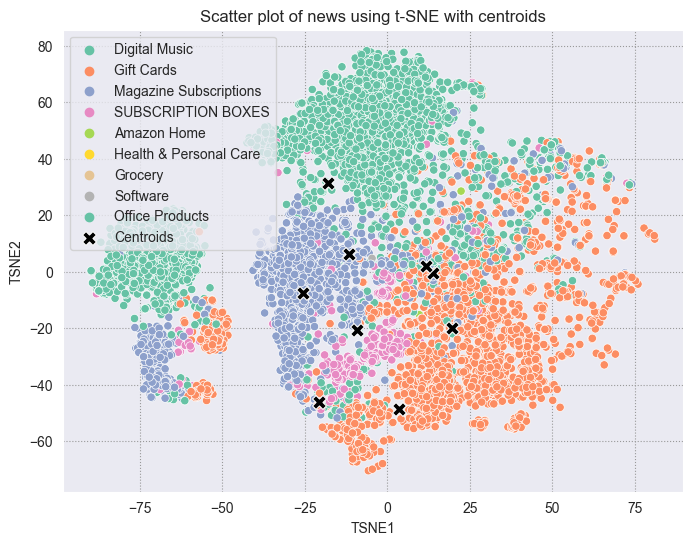

In [295]:
import seaborn as sns

# Plot the centroids against the cluster
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Class Name', palette='Set2');
sns.scatterplot(data=centroids, x='TSNE1', y='TSNE2', color="black", marker='X', s=100, label='Centroids')
# leg = ax.legend()
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news using t-SNE with centroids')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2');

In [291]:
# tsne = TSNE(random_state=0, n_iter=1000)
# tsne_results = tsne.fit_transform(text_embeddings)

# df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
# df_tsne['Class Name'] = sample_dataset["main_category"]
# df_tsne

# emb_c = get_embedding_centroids(sample_df, text_embeddings)
# # Plot the centroids against the cluster
# fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
# sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
# sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Class Name', palette='Set2');
# sns.scatterplot(data=centroids, x='TSNE1', y='TSNE2', color="black", marker='X', s=100, label='Centroids')
# # leg = ax.legend()
# # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
# plt.title('Scatter plot of news using t-SNE with centroids')
# plt.xlabel('TSNE1')
# plt.ylabel('TSNE2');

/Users/mouhaned.chebaane/Library/Caches/pypoetry/virtualenvs/abwab-homework-r5ZhboOE-py3.11/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


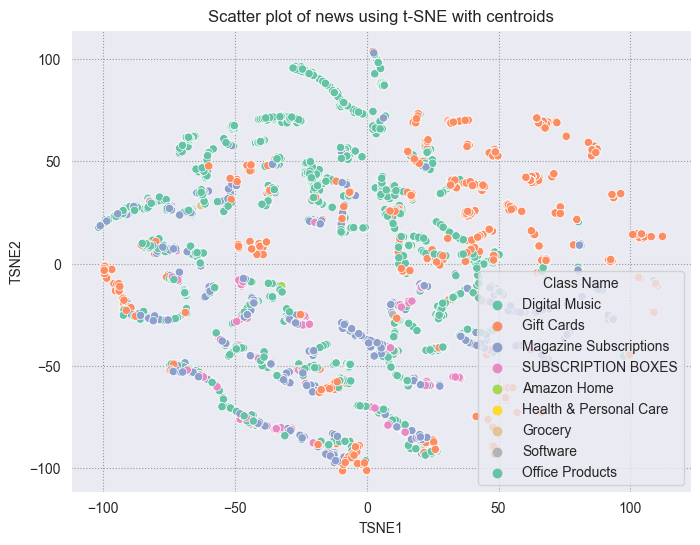

In [279]:
# Numerical features
tsne_numerical = TSNE(random_state=0, n_iter=1000)
tsne_numerical_results = tsne_numerical.fit_transform(df_scaled.values)
df_tsne_numerical = pd.DataFrame(tsne_numerical_results, columns=['TSNE1', 'TSNE2'])
df_tsne_numerical['Class Name'] = sample_dataset["main_category"]

# Plot the centroids against the cluster
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne_numerical, x='TSNE1', y='TSNE2', hue='Class Name', palette='Set2');
# sns.scatterplot(data=centroids, x='TSNE1', y='TSNE2', color="black", marker='X', s=100, label='Centroids')
# leg = ax.legend()
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news using t-SNE with centroids')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2');

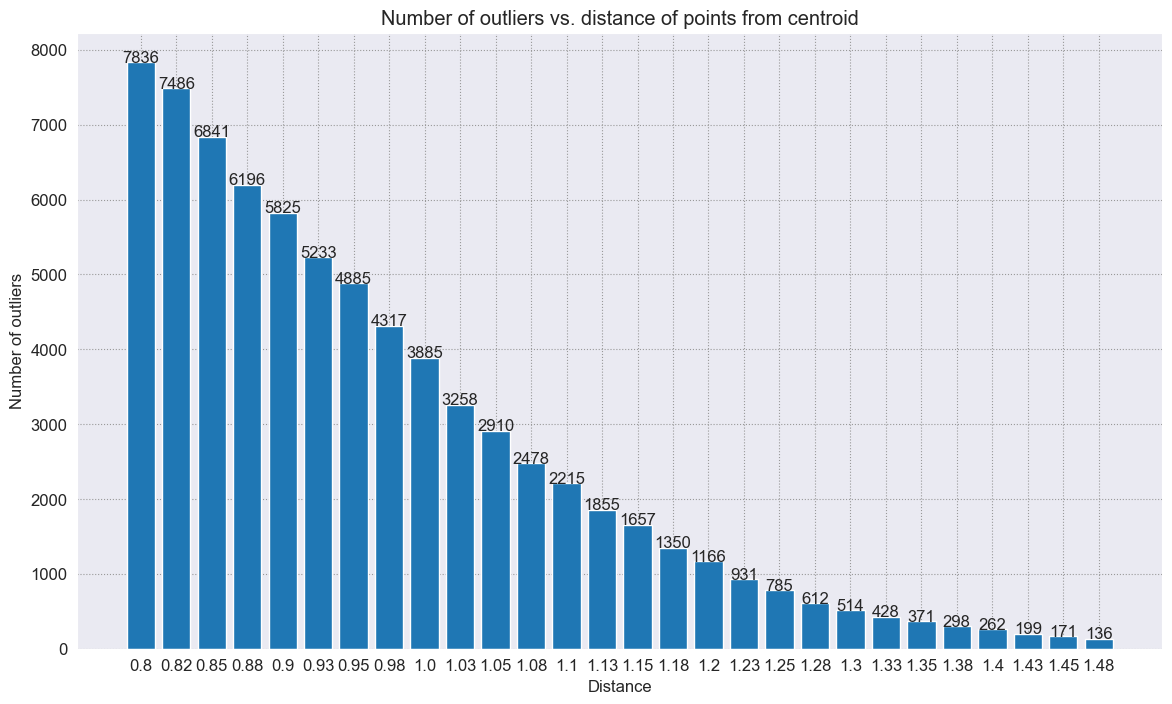

In [298]:
def calculate_euclidean_distance(p1, p2):
    return np.sqrt(np.sum(np.square(p1 - p2)))

def detect_outlier(df, emb_centroids, radius):
    for idx, row in df.iterrows():
        class_name = row['main_category'] # Get class name of row
        if not class_name:
            continue
        # Compare centroid distances
        dist = calculate_euclidean_distance(X_combined[idx,:],
                                            emb_centroids[class_name])
        df.at[idx, 'Outlier'] = dist > radius

    return len(df[df['Outlier'] == True])

range_ = np.arange(0.8, 1.5, 0.025).round(decimals=2).tolist()
num_outliers = []
for i in range_:
    num_outliers.append(detect_outlier(sample_df, emb_c, i))

# Plot range_ and num_outliers
fig = plt.figure(figsize = (14, 8))
plt.rcParams.update({'font.size': 12})
plt.bar(list(map(str, range_)), num_outliers)
plt.title("Number of outliers vs. distance of points from centroid")
plt.xlabel("Distance")
plt.ylabel("Number of outliers")
for i in range(len(range_)):
    plt.text(i, num_outliers[i], num_outliers[i], ha = 'center')

plt.show()

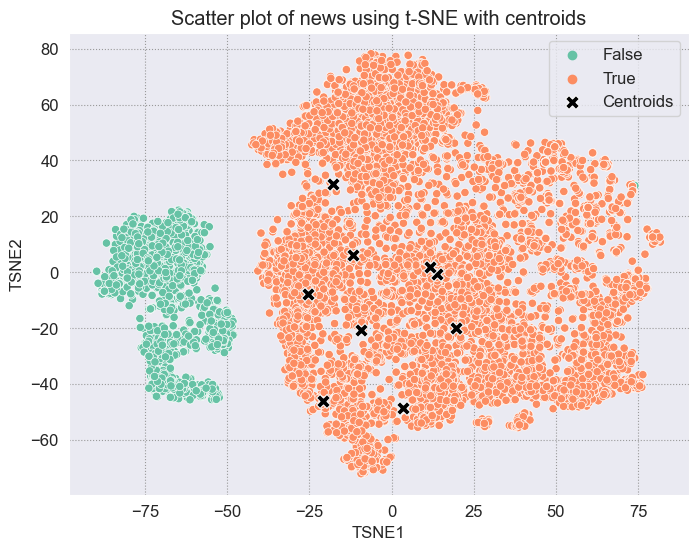

In [302]:
df_tsne['verified_purchase'] = sample_dataset["verified_purchase"]

fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='verified_purchase', palette='Set2');
sns.scatterplot(data=centroids, x='TSNE1', y='TSNE2', color="black", marker='X', s=100, label='Centroids')
# leg = ax.legend()
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news using t-SNE with centroids')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2');

In [346]:
RADIUS = 1.4
detect_outlier(sample_df, emb_c, RADIUS)
df_outliers = sample_df[sample_df['Outlier'] == True]
df_outliers.head()

,rating,title,title_text,text,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,main_category,...,average_rating,rating_number,features,description,price,store,categories,details,category_encoded,Outlier
19,1.0,One Star,One Star\nPlease stop trying to make money off...,Please stop trying to make money off the death...,B0052ZKRLA,AGBGFHYL3E7OVPUZVH4BHVBM2KQA,1526101995827,0,False,Digital Music,...,2.5,2,[],[],38.503569,GEEZINSLAW BROTHERS (Artist),[],"{""Manufacturer"": ""CAPITOL"", ""Date First Availa...",0.0,True
26,1.0,Not good from this account,Not good from this account\nNot an official li...,Not an official link. Do not buy,B07FNZ93LW,AEINHKYDQHQDYUUJGENX3DUT6LIA,1532013704218,4,False,Digital Music,...,4.7,773,[],[],38.503569,Format: Kitchen,[],{},0.0,True
151,1.0,Cute and impressive way to give a gift card,Cute and impressive way to give a gift card\nE...,Everyone I gave one to commented on how cool t...,B00ADR2LV6,AFFMSO2PAOCVZ5QCTJIN6BCOH52A,1641680741939,0,True,Gift Cards,...,4.9,185606,"[Gift Card is affixed inside a box, Gift amoun...",[],25.000000,Amazon,"[Gift Cards, Occasions, Chanukah]","{""Package Dimensions"": ""8.19 x 4.41 x 1.3 inch...",1.0,True
158,1.0,One Star,One Star\nThis is a bootleg. Made off of casse...,This is a bootleg. Made off of cassette or dow...,B00U7S2DPU,AHAOYTV2IO3YUI433LC3OLL46SAA,1446403068000,4,False,Digital Music,...,3.9,21,[],[],35.160000,Neil Young Crazy Horse Format: Audio CD,[],"{""Product Dimensions"": ""4.88 x 0.39 x 5.55 inc...",0.0,True
168,1.0,Caution -- NOT Proper-Sheppard's band!!!,"Caution -- NOT Proper-Sheppard's band!!!\nNo, ...","No, this is not an undiscovered gem by Robin P...",B000WMG4PQ,AGJA7KXM6PMPAN64VVDZDKTYUBVQ,1220888388000,17,False,Digital Music,...,1.0,1,[],[],14.750000,The God Machine Format: Audio CD,[],"{""Package Dimensions"": ""5.55 x 4.97 x 0.54 inc...",0.0,True


In [347]:
sample_df.verified_purchase.value_counts()

verified_purchase
True     8388
False    1612
Name: count, dtype: int64

In [348]:
df_outliers.verified_purchase.value_counts()

verified_purchase
False    215
True      47
Name: count, dtype: int64

In [349]:
outliers_projected = df_tsne.loc[df_outliers['Outlier'].index]


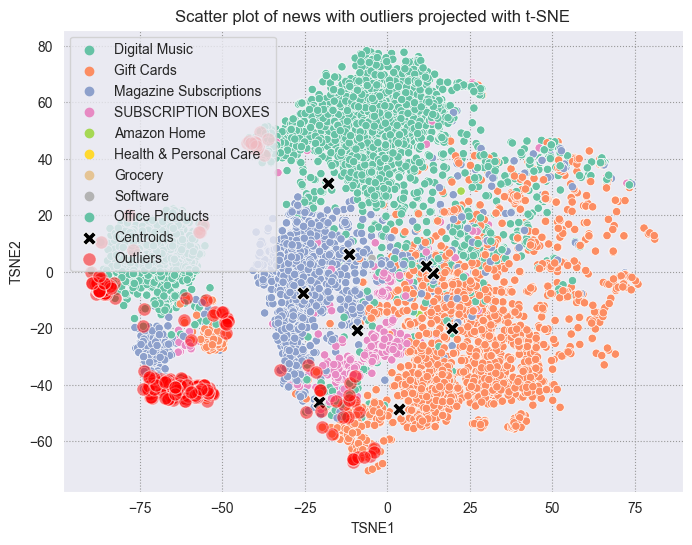

In [350]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
plt.rcParams.update({'font.size': 10})
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Class Name', palette='Set2');
sns.scatterplot(data=centroids, x='TSNE1', y='TSNE2', color="black", marker='X', s=100, label='Centroids')
# Draw a red circle around the outliers
sns.scatterplot(data=outliers_projected, x='TSNE1', y='TSNE2', color='red', marker='o', alpha=0.5, s=90, label='Outliers')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news with outliers projected with t-SNE')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2');

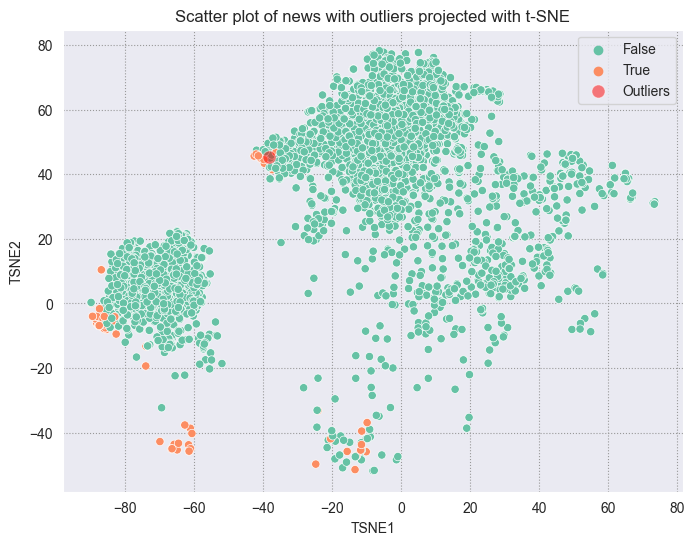

In [353]:
# sample_df[(sample_df['Outlier'] == True) & (df_outliers['main_category'] == "Digital Music")]
df_tsne['Outlier'] = sample_df["Outlier"]
df_tsne['main_category'] = sample_df["main_category"]
df_tsne['rating'] = sample_df["rating"]

fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
plt.rcParams.update({'font.size': 10})
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne[df_tsne['main_category'] == "Digital Music"], x='TSNE1', y='TSNE2', hue='Outlier', palette='Set2');
# Draw a red circle around the outliers
text = "Almost unlistenable. Maybe one decent version out of the entire CD. Not good."
sns.scatterplot(data=df_tsne.loc[sample_df.text.apply(lambda x: x.startswith(text))], x='TSNE1', y='TSNE2', color='red', marker='o', alpha=0.5, s=90, label='Outliers')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news with outliers projected with t-SNE')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2');

In [354]:
digitla_music_outliers = df_outliers[df_outliers['main_category'] == "Digital Music"]
digitla_music_outliers.rating.value_counts()

rating
1.0    84
2.0     7
5.0     3
Name: count, dtype: int64

In [351]:
digitla_music_outliers[["rating", "verified_purchase", "title", "text", "item_title", "store", "details"]].head(50).style

,rating,verified_purchase,title,text,item_title,store,details
19,1.000000,False,One Star,Please stop trying to make money off the death of my uncle!,the geezinslaws are alive (and well?),GEEZINSLAW BROTHERS (Artist),"{""Manufacturer"": ""CAPITOL"", ""Date First Available"": ""February 22, 2013"", ""Label"": ""CAPITOL""}"
26,1.000000,False,Not good from this account,Not an official link. Do not buy,[L ver] BTS - LOVE YOURSELF 結 'Answer' 2CD + Pre-order Benefit + Unfolded Poster,Format: Kitchen,{}
158,1.000000,False,One Star,This is a bootleg. Made off of cassette or download. Boycott this.,"YOUNG, NEIL & CRAZY HORSE - IN A RUSTED OUT GARAGE 1986",Neil Young Crazy Horse Format: Audio CD,"{""Product Dimensions"": ""4.88 x 0.39 x 5.55 inches; 3.1 Ounces"", ""Manufacturer"": ""Air Cuts"", ""Date First Available"": ""March 7, 2015"", ""Label"": ""Air Cuts"", ""Country of Origin"": ""France"", ""Number of discs"": ""1""}"
168,1.000000,False,Caution -- NOT Proper-Sheppard's band!!!,"No, this is not an undiscovered gem by Robin Propper-Sheppard's God Machine! This ""God Machine"" is a four piece band from the Seattle Washington area. Truly below-average hard rock of the minimally-imaginative, only-partially-intelligible variety. Next...",Law of Retailiation,The God Machine Format: Audio CD,"{""Package Dimensions"": ""5.55 x 4.97 x 0.54 inches; 3.1 Ounces"", ""Date First Available"": ""October 30, 2012""}"
234,1.000000,False,garbage musical quality!,"what a garbage this band is! the answer of the german teeny girl band for SPICE GIRLS in the UK. The girls are pretty but they do not show us any capability how they could play any of instruments on stage, and neither they could read any of the musical notes.the germans keep on saying ""SCHROTT""",Elle Ments,No Angels Format: Audio CD,"{""Package Dimensions"": ""5.55 x 4.97 x 0.54 inches; 2.82 Ounces"", ""Manufacturer"": ""xxx"", ""Date First Available"": ""February 11, 2007"", ""Label"": ""xxx"", ""Number of discs"": ""1""}"
311,1.000000,True,False advertising,"Not 7"" Square Shaped Flexi Disc","Dangerous (7"" Square Shaped Flexi Disc)(RSD Exclusive)",Big Data (Artist) Format: Accessory,"{""Package Dimensions"": ""7 x 6.8 x 0.02 inches; 0.35 Ounces"", ""Manufacturer"": ""Warner Bros."", ""Date First Available"": ""April 15, 2015"", ""Label"": ""Warner Bros."", ""Number of discs"": ""1""}"
509,1.000000,True,Damaged,Everything was fine but it have something like oil in the corner on the back.,iKON Bobby - [Love And Fall] 1st Solo Album Love Ver CD+PhotoBook+PhotoCard+Graphic Sticker+Lyrics Poster K-POP SEALED,BOBBY Format: Audio CD,"{""Brand"": ""AZZUTORK"", ""Special Feature"": ""Flat"", ""Included Components"": ""Stand"", ""Package Dimensions"": ""8.5 x 6.26 x 0.51 inches; 12.56 Ounces"", ""Manufacturer"": ""YG Entertainment"", ""Date First Available"": ""October 2, 2017"", ""Label"": ""YG Entertainment""}"
532,1.000000,True,One Star,Cover and sleeve in deplorable condition. Would not have purchased if knew this.,The Many Voices of Miriam Makeba,Miriam Makeba (Author) Format: Unknown Binding,"{""Package Dimensions"": ""12.1 x 12.1 x 0.2 inches; 8.8 Ounces"", ""Manufacturer"": ""Kapp Records"", ""Date First Available"": ""January 15, 2008"", ""Label"": ""Kapp Records""}"
674,1.000000,True,Disappointed,"I ordered this CD because I was having a hard time with my 2 year old as far as naps and sleeping through the night. We had previously used The Sleepeasy Solution with him when he was younger and it worked great however I couldn't find my copy of the book. When I got this CD, it became apparent that it was geared more towards 18-24 months old who are still in their cribs (my son has been in a toddler bed for a while). Also, there was not any new information than what I had remembered from the original book. Save yourself the money and just purchase the Sleepeasy Solution book.",Sleepeasy for Toddlers 12 to 24 Months,Jill Spivack and Jennifer Waldburger (Artist) Format: Audio CD,"{""Is Discont

In [19]:
item_dataset.info.dataset_size, dataset.info.dataset_size

AttributeError: 'DatasetDict' object has no attribute 'info'

In [14]:
172622.243 / 1024

168.5764091796875

In [15]:
import sys
sys.getsizeof(item_dataset)

56

In [ ]:
All_Beauty.jsonl
Subscription_Boxes.jsonl
Magazine_Subscriptions.jsonl
Health_and_Personal_Care.jsonl
Handmade_Products.jsonl
Gift_Cards.jsonl
Digital_Music.jsonl
Appliances.jsonl
